In [270]:
import os
import cv2
from SegTracker import SegTracker
from model_args import aot_args,sam_args,segtracker_args
from PIL import Image
from aot_tracker import _palette
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import gc
import json

def save_prediction(pred_mask,output_dir,file_name):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask.save(os.path.join(output_dir,file_name))
def colorize_mask(pred_mask):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask = save_mask.convert(mode='RGB')
    return np.array(save_mask)
def draw_mask(img, mask, alpha=0.5, id_countour=False):
    img_mask = np.zeros_like(img)
    img_mask = img
    if id_countour:
        # very slow ~ 1s per image
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[obj_ids!=0]

        for id in obj_ids:
            # Overlay color on  binary mask
            if id <= 255:
                color = _palette[id*3:id*3+3]
            else:
                color = [0,0,0]
            foreground = img * (1-alpha) + np.ones_like(img) * alpha * np.array(color)
            binary_mask = (mask == id)

            # Compose image
            img_mask[binary_mask] = foreground[binary_mask]

            countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
            img_mask[countours, :] = 0
    else:
        binary_mask = (mask!=0)
        countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
        foreground = img*(1-alpha)+colorize_mask(mask)*alpha
        img_mask[binary_mask] = foreground[binary_mask]
        img_mask[countours,:] = 0
        
    return img_mask.astype(img.dtype)

In [271]:
# function to get annotations from the json file
def get_annotations(json_file):
    # Read the JSON data from the file
    data = None
    with open(json_file, 'r') as file:
        data = json.load(file)

    annotations = []
    # Iterate over each image in the JSON data
    for image_data in data:
        image_path = image_data['image']
        index = image_path.index("test-images")
        image_path = image_path[index:]
        image_path = image_path.replace("X", "/")
        original_width = image_data['label'][0]['original_width']
        original_height = image_data['label'][0]['original_height']
        
        # Create a dictionary to store the bounding boxes for each label
        bounding_boxes = {}
        
        # Iterate over each annotation for the current image
        for annotation in image_data['label']:
            label = annotation['rectanglelabels'][0]
            
            # Extract the bounding box coordinates
            x = annotation['x']
            y = annotation['y']
            width = annotation['width']
            height = annotation['height']
            
            # Scale the coordinates to the original image dimensions
            x_scaled = int(x * original_width / 100)
            y_scaled = int(y * original_height / 100)
            width_scaled = int(width * original_width / 100)
            height_scaled = int(height * original_height / 100)
            
            # Calculate the xyxy coordinates
            x1 = x_scaled
            y1 = y_scaled
            x2 = x_scaled + width_scaled
            y2 = y_scaled + height_scaled
            
            # Add the bounding box coordinates to the dictionary
            if label not in bounding_boxes:
                bounding_boxes[label] = []
            bounding_boxes[label].append([x1, y1, x2, y2])
        
        annotations.append((image_path, bounding_boxes))

    ann_np = np.array(annotations)
    return ann_np

### Set parameters for input and output

In [272]:
video_name = 'images0'
video_path = '/home/yashas/Documents/thesis/test-images/group_1/traj49/images0'
io_args = {
    'input_video': f'{video_path}/{video_name}.mp4',
    'output_mask_dir': f'{video_path}/{video_name}_masks', # save pred masks
    'output_video': f'{video_path}/{video_name}_seg.mp4', # mask+frame vizualization, mp4 or avi, else the same as input video
    'output_gif': f'{video_path}/{video_name}_seg.gif', # mask visualization
}
print(io_args['input_video'])

/home/yashas/Documents/thesis/test-images/group_1/traj49/images0/images0.mp4


In [273]:
json_file = "/home/yashas/Documents/thesis/thesis_working/testset_annotations.json"
annotations = get_annotations(json_file)

image_path = video_path + '/im_0.jpg'
image_path = image_path[image_path.index("test-images"):]

# Get the annotations for the current image
image_annotations = annotations[annotations[:, 0] == image_path][0][1]
print(image_annotations)
print(image_annotations.keys())
print(image_annotations['gripper'])
boxes = []
boxes.append(image_annotations['gripper'][0])
boxes.append(image_annotations['table'][0])
boxes.append(image_annotations['yellow_block'][0])
boxes.append(image_annotations['green_block'][0])
boxes.append(image_annotations['blue_block'][0])
boxes.append(image_annotations['red_block'][0])
print(boxes)

{'gripper_center': [[333, 76, 341, 84]], 'table_center': [[306, 290, 314, 297]], 'yellow_block_center': [[277, 252, 282, 259]], 'green_block_center': [[405, 281, 411, 289]], 'blue_block_center': [[209, 166, 214, 172]], 'red_block_center': [[538, 292, 544, 302]], 'yellow_block': [[248, 217, 316, 307]], 'green_block': [[368, 246, 450, 338]], 'blue_block': [[179, 151, 254, 200]], 'red_block': [[507, 253, 568, 359]], 'gripper': [[262, 0, 418, 198]], 'table': [[4, 74, 639, 479]]}
dict_keys(['gripper_center', 'table_center', 'yellow_block_center', 'green_block_center', 'blue_block_center', 'red_block_center', 'yellow_block', 'green_block', 'blue_block', 'red_block', 'gripper', 'table'])
[[262, 0, 418, 198]]
[[262, 0, 418, 198], [4, 74, 639, 479], [248, 217, 316, 307], [368, 246, 450, 338], [179, 151, 254, 200], [507, 253, 568, 359]]


### Tuning SAM on the First Frame for Good Initialization

final text_encoder_type: bert-base-uncased
Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
SegTracker has been initialized
processed frame 0, obj_num 6


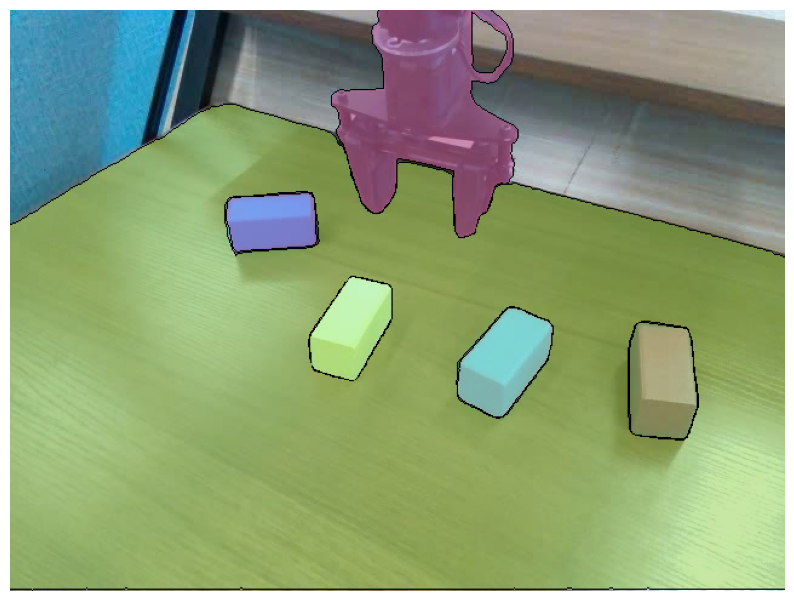

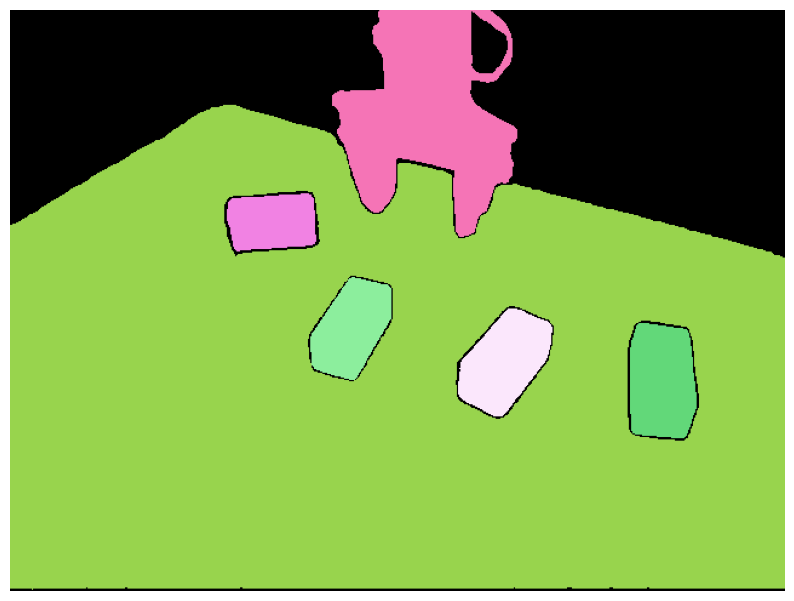

In [274]:
# choose good parameters in sam_args based on the first frame segmentation result
# other arguments can be modified in model_args.py
# note the object number limit is 255 by default, which requires < 10GB GPU memory with amp
sam_args['generator_args'] = {
        'points_per_side': 20,
        'pred_iou_thresh': 0.8,
        'stability_score_thresh': 0.8,
        # 'crop_n_layers': 1,
        # 'crop_n_points_downscale_factor': 2,
        'box_nms_thresh': 0.2,
        'min_mask_region_area': 50,
    }
cap = cv2.VideoCapture(io_args['input_video'])
frame_idx = 0
segtracker = SegTracker(segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()
with torch.cuda.amp.autocast():
    while cap.isOpened():
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        # pred_mask = segtracker.seg(frame)
        # segtracker.
        pred_mask = segtracker.seg_with_boxes(frame,boxes)
        segtracker.first_frame_mask = pred_mask
        segtracker.add_reference(frame, pred_mask, frame_idx)
        
        torch.cuda.empty_cache()
        obj_ids = np.unique(pred_mask)
        obj_ids = obj_ids[obj_ids!=0]
        print("processed frame {}, obj_num {}".format(frame_idx,len(obj_ids)),end='\n')
        break
    cap.release()
    init_res = draw_mask(frame,pred_mask,id_countour=False)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(init_res)
    plt.show()
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(colorize_mask(pred_mask))
    plt.show()

    del segtracker
    torch.cuda.empty_cache()
    gc.collect()

### Generate Results for the Whole Video

In [275]:
# For every sam_gap frames, we use SAM to find new objects and add them for tracking
# larger sam_gap is faster but may not spot new objects in time
segtracker_args = {
    'sam_gap': 10000000, # the interval to run sam to segment new objects
    'min_area': 200, # minimal mask area to add a new mask as a new object
    'max_obj_num': 255, # maximal object number to track in a video
    'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
}

# source video to segment
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)
# output masks
output_dir = io_args['output_mask_dir']
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
pred_list = []
masked_pred_list = []

torch.cuda.empty_cache()
gc.collect()
sam_gap = segtracker_args['sam_gap']
frame_idx = 0
segtracker = SegTracker(segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()

with torch.cuda.amp.autocast():
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        if frame_idx == 0:
            # pred_mask = segtracker.seg(frame)
            pred_mask = segtracker.seg_with_boxes(frame,boxes)
            segtracker.first_frame_mask = pred_mask
            torch.cuda.empty_cache()
            gc.collect()
            segtracker.add_reference(frame, pred_mask)
        elif (frame_idx % sam_gap) == 0:
            seg_mask = segtracker.seg(frame)
            torch.cuda.empty_cache()
            gc.collect()
            track_mask = segtracker.track(frame)
            # find new objects, and update tracker with new objects
            new_obj_mask = segtracker.find_new_objs(track_mask,seg_mask)
            # save_prediction(new_obj_mask,output_dir,str(frame_idx)+'_new.png')
            pred_mask = track_mask + new_obj_mask
            # segtracker.restart_tracker()
            segtracker.add_reference(frame, pred_mask)
        else:
            pred_mask = segtracker.track(frame,update_memory=True)
        torch.cuda.empty_cache()
        gc.collect()
        save_prediction(pred_mask,output_dir,str(frame_idx)+'.png')

        # output pred_mask array to file as pickle file
        seg_dir = f'{video_path}/segmentations'
        if not os.path.exists(seg_dir):
            os.makedirs(seg_dir)
        np.save(f'{seg_dir}/{frame_idx}.npy',pred_mask)

        # masked_frame = draw_mask(frame,pred_mask)
        # masked_pred_list.append(masked_frame)
        # plt.imshow(masked_frame)
        # plt.show() 
        
        pred_list.append(pred_mask)
        
        
        print("processed frame {}, obj_num {}".format(frame_idx,segtracker.get_obj_num()),end='\r')
        frame_idx += 1
    cap.release()
    print('\nfinished')

final text_encoder_type: bert-base-uncased
Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
SegTracker has been initialized
processed frame 37, obj_num 6
finished


### Save results for visualization

In [276]:
# draw pred mask on frame and save as a video
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if io_args['input_video'][-3:]=='mp4':
    fourcc =  cv2.VideoWriter_fourcc(*"mp4v")
elif io_args['input_video'][-3:] == 'avi':
    fourcc =  cv2.VideoWriter_fourcc(*"MJPG")
    # fourcc = cv2.VideoWriter_fourcc(*"XVID")
else:
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
out = cv2.VideoWriter(io_args['output_video'], fourcc, fps, (width, height))

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    pred_mask = pred_list[frame_idx]
    masked_frame = draw_mask(frame,pred_mask)
    # masked_frame = masked_pred_list[frame_idx]
    masked_frame = cv2.cvtColor(masked_frame,cv2.COLOR_RGB2BGR)
    out.write(masked_frame)
    print('frame {} writed'.format(frame_idx),end='\r')
    frame_idx += 1
out.release()
cap.release()
print("\n{} saved".format(io_args['output_video']))
print('\nfinished')

frame 37 writed
/home/yashas/Documents/thesis/test-images/group_1/traj49/images0/images0_seg.mp4 saved

finished


In [277]:
# load and print .npy files created during segmentation
seg_dir = f'{video_path}/segmentations'
for file in os.listdir(seg_dir):
    if file.endswith('.npy'):
        pred_mask = np.load(os.path.join(seg_dir,file))
        print(pred_mask)
        break

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [2 2 2 ... 2 2 2]
 [0 0 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [278]:
# save colorized masks as a gif
imageio.mimsave(io_args['output_gif'],pred_list,fps=fps)
print("{} saved".format(io_args['output_gif']))

/home/yashas/Documents/thesis/test-images/group_1/traj49/images0/images0_seg.gif saved


In [279]:
# manually release memory (after cuda out of memory)
del segtracker
torch.cuda.empty_cache()
gc.collect()

11